# Performing the Higgs -> WW-> 2 leptons search 





# Installation of packages not available by default on colab


In [ ]:
import sys
# update the pip package installer
#%pip install --upgrade --user pip
# install required packages
#%pip install --upgrade --user uproot awkward vector numpy matplotlib

!pip install uproot
!pip install vector
!pip install awkward
!pip install hist

## Import packages used in the analysis

We're going to be using a number of tools to help us:
* uproot: lets us read .root files typically used in particle physics into data formats used in python
* awkward: lets us store data as awkward arrays, a format that generalizes numpy to nested data with possibly variable length lists
* vector: to allow vectorized 4-momentum calculations
* numpy: provides numerical calculations such as histogramming
* matplotlib: common tool for making plots, figures, images, visualisations

In [1]:
import uproot # for reading .root files
import awkward as ak # to represent nested data in columnar format
import vector # for 4-momentum calculations
import time # to measure time to analyse
import math # for mathematical functions such as square root
import numpy as np # for numerical calculations such as histogramming
import matplotlib.pyplot as plt
import pandas as pd


## Data fraction, file path

General definitions of fraction of data used, where to access the input files

In [2]:
#lumi = 0.5 # fb-1 # data_A only
#lumi = 1.9 # fb-1 # data_B only
#lumi = 2.9 # fb-1 # data_C only
#lumi = 4.7 # fb-1 # data_D only
lumi = 10 # fb-1 # data_A,data_B,data_C,data_D
fraction = 10000 # reduce this is if you want the code to run quicker

<a id='fraction'></a>

In [3]:
tuple_path = "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/2lep/" # web address

Units, as stored in the data files.<br /> 
The quantities in the ATLAS ntuple are unfortunately stored in MeV.<br />
Since the natural unit for LHC analysis is GeV, we define conversion factors

In [4]:
MeV = 0.001
GeV = 1.0
mz = 91.12

Define different classes of ntuples to access as a dictionary called "samples".<br />
One has four types of ntuples:<br />
<ul>
<li>Data: the real data collected by ATLAS at the LHC
<li>Reducible backgrounds: 
<li>Irreducible backgrounds
<li>Signal
</ul>
The names in the list must correspond to the names of a sample defined in infofile.py

In [5]:
samples = {
#  'data': {
#    'list' : ['data_A','data_B','data_C','data_D'],
#  },
#  'reducible' : { # ttbar
#     'list' : ['ttbar_lep'],
#     'color' : "#6b59d3" # purple
#  },
  'background' : { # WW
     'list' : ['llvv'],
     'color' : "#ff0000" # red
  },
  'signal' : { # H -> WW -> llvv
     'list' : ['ggH125_WW2lep'],
     'color' : "#00cdff" # light blue
  },
}

In [6]:
import os.path
if os.path.isfile('infofile.py')==False:
  !wget https://raw.githubusercontent.com/atlas-outreach-data-tools/notebooks-collection-opendata/master/13-TeV-examples/uproot_python/infofile.py    
import infofile    
#!head -n 12 infofile.py

In [7]:
def get_xsec_weight(sample):
  info = infofile.infos[sample] # open infofile
  xsec_weight = (lumi*1000*info["xsec"])/(info["sumw"]*info["red_eff"]) #*1000 to go from fb-1 to pb-1
  return xsec_weight # return cross-section weight

def calc_weight(xsec_weight, events):
    return (
        xsec_weight
        * events.mcWeight
        * events.scaleFactor_PILEUP
        * events.scaleFactor_ELE
        * events.scaleFactor_MUON
        * events.scaleFactor_LepTRIGGER
    )

In [8]:
def get_data_from_files():

  data = {} # define empty dictionary to hold dataframes
  statMC = {}
  for s in samples: # loop over samples
    print('Processing '+s+' samples') # print which sample
    frames = [] # define empty list to hold data
    stattot=0
    for val in samples[s]['list']: # loop over each file
      if s == 'data': prefix = "Data/" # Data prefix
      else: # MC prefix
        prefix = "MC/mc_"+str(infofile.infos[val]["DSID"])+"."
      fileString = tuple_path+prefix+val+".2lep.root" # file name to open
      temp, stats = read_file(fileString,val) # call the function read_file defined below
      stattot=stattot+stats
      frames.append(temp) # append dataframe returned from read_file to list of dataframes
    data[s] = pd.concat(frames) # dictionary entry is concatenated dataframes
    statMC[s]=stattot

  return data, statMC# return dictionary of dataframes

Define function to calculate kinematic quantities based on components of two leptons and Etmiss.<br />
It accesses the dataframe where the particle data are stored as scalar components, and creates an 
array of 4-vectors with the vector library<br />
The variables are then built using the 4-vector algebra

In [9]:
def calc_kine(dff):
    pl1=vector.array({"pt":dff["ptl1"], "phi":dff["phil1"],
       "eta":dff["etal1"], "e":dff["el1"]})
    pl2=vector.array({"pt":dff["ptl2"], "phi":dff["phil2"],
       "eta":dff["etal2"], "e":dff["el2"]})
    etmv=vector.array({"pt":dff["met_et"], "phi":dff["met_phi"]})
    etm=dff["met_et"]
    pll=pl1+pl2
    ptllv=vector.array({"x":pll.x, "y":pll.y})
    c2=(etmv.x+ptllv.x)**2+(etmv.y+ptllv.y)**2
    dphill=pl1.deltaphi(pl2)
    dphillm=pll.deltaphi(etmv)
    mll=pll.M
    ptll=pll.pt
    etll=np.sqrt(ptll*ptll+mll*mll)
    c1=(etll+etm)**2
    mt=np.sqrt(c1-c2)
    return mll,dphill,ptll,dphillm,mt

Calculate the angular difference in transverse plane between each of the leptons and the Etmiss vector.<br />
They will be used to reduce number of variables exploiting the azimuthal invariance of the events

In [10]:
def calc_dphil1m(dff):
    pl=vector.array({"pt":dff["ptl1"], "phi":dff["phil1"],
       "eta":dff["etal1"], "e":dff["el1"]})
    em=vector.array({"pt":dff["met_et"], "phi":dff["met_phi"]})
    return pl.deltaphi(em)
def calc_dphil2m(dff):
    pl=vector.array({"pt":dff["ptl2"], "phi":dff["phil2"],
       "eta":dff["etal2"], "e":dff["el2"]})
    em=vector.array({"pt":dff["met_et"], "phi":dff["met_phi"]})
    return pl.deltaphi(em)

Simple template for a selection function acting on the dataframe, it creates a boolean. Implement selections on the quality of leptons

In [11]:
def cut_iso(df):
   isol1=(df["ptcl1"]/df["ptl1"]<0.2) & (df["etcl1"]/df["ptl1"]<0.2)
   isol2=(df["ptcl2"]/df["ptl2"]<0.2) & (df["etcl2"]/df["ptl2"]<0.2)
   return isol1 & isol2
def cut_ossf(df):
   ltc1=df["chl1"]*df["typl1"]
   ltc2=df["chl2"]*df["typl2"]
   return (ltc1+ltc2!=0) & ((df["chl1"]+df["chl2"])>0) 
def cut_tight(df):
   return (df["tightl1"]==1) & (df["tightl2"]==1)

Define function to get data from files.

The datasets used in this notebook have already been filtered to include at least 4 leptons per event

In [12]:
def read_file(path, sample):
  with uproot.open( path + ":mini") as tree:
    numevents = tree.num_entries # number of events
    stopev=numevents*fraction
    if fraction>1:
      stopev=fraction
    if 'data' not in sample: 
      xsec_weight = get_xsec_weight(sample) # get cross-section weight
      print('sample xs weight',xsec_weight,'totev ',xsec_weight*numevents )    
# variables to extract from ntuple are separated 
    lepvar=["lep_pt", "lep_eta", "lep_phi","lep_E",
          "lep_charge","lep_type",
          "lep_ptcone30","lep_etcone20", "lep_isTightID"]
    scalvar=["met_et","met_phi","jet_n"]
    weivar=["mcWeight","scaleFactor_PILEUP",
            "scaleFactor_ELE","scaleFactor_MUON",
            "scaleFactor_LepTRIGGER"] # variables to calculate Monte Carlo weight
    tupvar=weivar+lepvar+scalvar
# read tree into awkward array with uproot
    print("num",numevents, stopev)
    lep_momentum = tree.arrays(tupvar,entry_stop=stopev,library="ak")
# define the names of the variables to go into dataframe
    colnam=["ptl1","etal1","phil1","el1","chl1","typl1","ptcl1","etcl1","tightl1",
          "ptl2","etal2","phil2","el2","chl2","typl2","ptcl2","etcl2","tightl2"]
# create numpy vector assuming that lep_ arrays have 4 components
    for i in range(0,2):
      for j in range(0,len(lepvar)):
        if i==0 and j==0:
          ptlep=ak.to_numpy(lep_momentum[lepvar[j]][:,i])
        else:
          ptlep=np.vstack([ptlep,ak.to_numpy(lep_momentum[lepvar[j]][:,i])])
# end up with numpy 2d vector with n_var rows and n_event columns
# to transpose, as in pandas 'features' are columns and 'observations' rows
    ptlep=ptlep.transpose()
# create dataframe 
    df = pd.DataFrame(ptlep)
# add names of columns
    df.columns=colnam 
# add scalar variables
    for i in range(0, len(scalvar)):
      df[scalvar[i]]=lep_momentum[scalvar[i]]
#   calculate dphi rotation variables
    df["dphil1m"]=calc_dphil1m(df)
    df["dphil2m"]=calc_dphil2m(df)
#   calculate lepton-lepton variables
    mll,dphill,ptll,dphillm,mt=calc_kine(df)
    df["dphill"]=np.abs(dphill)
    df["dphillm"]=np.abs(dphillm)
    df["mll"]=mll
    df["ptll"]=ptll
    df["mt"]=mt
# add MC weights and signal/background labelling
    if 'data' not in sample: # only do this for Monte Carlo simulation files
# multiply all Monte Carlo weights and scale factors together to give total weight
      wei=calc_weight(xsec_weight, lep_momentum)*numevents/stopev
      numevscal=sum(wei)
      print(" events with MC weight: ", numevscal)
      df["totalWeight"] = wei
      
      if  'H125' in sample:
        df["SIG"]=np.ones(df.shape[0])
      else:
        df["SIG"]=np.zeros(df.shape[0])
    print("dataframe after preselection " ,df.shape)
    return df, numevscal

# Run the reading of files

In [13]:
start = time.time() # time at start of whole processing
df, statMC = get_data_from_files() #process all files
print(df.keys())
print(statMC)
elapsed = time.time() - start # time after whole processing
print("Time taken: "+str(round(elapsed,1))+"s") # print total time taken to process every file

Processing background samples
sample xs weight 0.02473775926465947 totev  84332.08505687251
num 3409043 10000
 events with MC weight:  24507.76918829738
dataframe after preselection  (10000, 30)
Processing signal samples
sample xs weight 2.652880224948454e-05 totev  16.67826004221719
num 628685 10000
 events with MC weight:  422.1956684700628
dataframe after preselection  (10000, 30)
dict_keys(['background', 'signal'])
{'background': 24507.76918829738, 'signal': 422.1956684700628}
Time taken: 36.8s


## Apply preselections or add secondary variables if desired to separate datafranes

Define routine which loops over all the samples in the dictionary of dataframes and applies
selections on them. <br />
It would be simpler to apply the cuts when reading the files, but in this way you can play with 
the selections without the need of reloading the files every time<br />
One can also create dataframes with different selection levels and compare them

In [14]:
def add_columns(df):

  data = {} # define empty dictionary to hold dataframes
  for s in samples: # loop over samples
    print('Add columns '+s+' samples') # print which sample
    print('before', df[s].shape) 
    adddf=df[s] 
#   put here def of new variable
    data[s]=adddf

  return data # return dictionary of dataframes

def apply_selections(df):

  data = {} # define empty dictionary to hold dataframes
  for s in samples: # loop over samples
    print('Apply selections on '+s+' samples') # print which sample
    print('before', df[s].shape) 
    seldf=df[s]
    seldf=seldf.query("ptl1>20000")
    print('after',seldf.shape)
    data[s]=seldf
#    data[s] = pd.concat(frames) # dictionary entry is concatenated dataframes

  return data # return dictionary of dataframes

In [15]:
# Calculate events for available samples in dataframe dictionary normalised
# to available statistics
def calc_events(df):
  stat = {} # define empty dictionary to hold stat
  for s in samples: # loop over samples
    if s not in ['data']: 
      print('Calculate events on '+s+' samples') # print which sample
      stat[s]=(df[s]['totalWeight']).sum()
    if s in ['data']:
      stat[s]=df[s].shape[0]
  return stat # return dictionary of statistics

## Look at statistics before preselection

In [16]:
finstat=calc_events(df)
nsig=finstat['signal']
nbg=finstat['background']
print(nsig,nbg)

Calculate events on background samples
Calculate events on signal samples
422.19566847006445 24507.769188297352


## Apply preselections and check  numbers of events normalised to statistics

In [17]:
dfs=apply_selections(df)

Apply selections on background samples
before (10000, 30)
after (10000, 30)
Apply selections on signal samples
before (10000, 30)
after (10000, 30)


In [18]:
finstat1=calc_events(dfs)
nsig1=finstat1['signal']
nbg1=finstat1['background']
print(nsig1,nbg1)


Calculate events on background samples
Calculate events on signal samples
422.19566847006445 24507.769188297352


# Prepare data for ML analysis

## Fist step: build dataframes on which the analysis will be performed.<br />

* Concatenate signal and background files
* Randomize the distribution such that signal and background are randomly mixed
* To allow visualisation remove events with very high values of the unbounded variables
* Split out of the samples the events with row numbering above a given number to be used as a validation sample in the following

In [19]:
# choose the features for training
tfea = ['SIG','ptl1','ptl2','dphil1m','dphil2m','etal1','etal2','met_et','mll','mt','ptll','dphill','dphillm'] # list of features for discriminant analysis
# concatenate all samples
df_all=pd.concat(df[key][tfea] for key in df)
for key in df:
   print(key,df[key].shape[0])
df_all.columns=tfea
#print(df_all.keys)
# randomize it
#df_all=df_all.sample(frac=1)
# kludge, put reasonable upper limit on unbounded variables to allow automatic plotting
# in a reasobnable range
#df_all=df_all.query("ptl1<500000 & ptl2<250000 & met_et<500000 & mll<500000 & mt<1000000 & ptll<500000")

background 10000
signal 10000


## Definition of training and test samples

As usual use train_test_split from sklearn library

In [20]:
from sklearn.model_selection import train_test_split
#Define vectors for input to ML
# Use 'SIG' column as definition of target
y = df_all['SIG']

X = df_all[[col for col in df_all.columns if col!="SIG"]]
col_fin=X.columns
print(col_fin)
print(X.shape)
X_traina, X_testu, y_traina, y_test = train_test_split(X, y,
                                   test_size=.25, random_state=0)
# now further split train sample in actual train and validation
X_trainu, X_valu, y_train, y_val = train_test_split(X_traina, y_traina,
                                   test_size=.10, random_state=0)




Index(['ptl1', 'ptl2', 'dphil1m', 'dphil2m', 'etal1', 'etal2', 'met_et', 'mll',
       'mt', 'ptll', 'dphill', 'dphillm'],
      dtype='object')
(20000, 12)


## Scaling of samples so that all of the variables  are in the same range

Needed to make life easier for ML<br />
Use StandardScaler method from sklearn library

In [21]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() # initialise StandardScaler
print(X_trainu.columns)
# Fit only to the training data
scaler.fit(X_trainu)

# Now apply the transformations to the data:
X_train = scaler.transform(X_trainu)
X_test = scaler.transform(X_testu)
X_test=pd.DataFrame(X_test)
X_val=scaler.transform(X_valu)
print('train ', X_train.shape)
dfy=pd.DataFrame(y_train)
print('ytrain nbg',dfy.query("SIG==0").shape,'ytrain nsig',dfy.query("SIG==1").shape)
print('test', X_test.shape)
print('val', X_val.shape)

Index(['ptl1', 'ptl2', 'dphil1m', 'dphil2m', 'etal1', 'etal2', 'met_et', 'mll',
       'mt', 'ptll', 'dphill', 'dphillm'],
      dtype='object')
train  (13500, 12)
ytrain nbg (6724, 1) ytrain nsig (6776, 1)
test (5000, 12)
val (1500, 12)


# Logistic regression

Implement in Keras and run

In [22]:
import tensorflow
print(tensorflow.__version__)
from tensorflow import keras
#from keras.utils import plot_model
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
import warnings

varnum=X_train.shape[1]
model = keras.Sequential()
model.add(keras.layers.Dense(1, input_dim=varnum, activation='sigmoid'))
model.summary()

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history=model.fit(X_train, y_train, 
                  validation_data=(X_val,y_val), 
                  batch_size=100, epochs=100)

2023-05-16 16:50:24.268562: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-16 16:50:24.311798: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-16 16:50:24.312039: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-16 16:50:25.077634: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.12.0
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 13        
                                                                 
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
135/135 [==============================] - 0s 2ms/step - loss: 0.8533 - accuracy: 0.5139 - val_loss: 0.6901 - val_accuracy: 0.6020
Epoch 2/100
135/135 [==============================] - 0s 1ms/step - loss: 0.5905 - accuracy: 0.6803 - val_loss: 0.5718 - val_accuracy: 0.7087
Epoch 3/100
135/135 [==============================] - 0s 1ms/step - loss: 0.5158 - accuracy: 0.7485 - val_loss: 0.5243 - val_accuracy: 0.7507
Epoch 4/100
135/135 [==============================] - 0s 1ms/step - loss: 0.4806 - accuracy: 0.7735 - val_loss: 0.4982 - val_accuracy: 0.7700
Epoch 5/1

135/135 [==============================] - 0s 1ms/step - loss: 0.3738 - accuracy: 0.8367 - val_loss: 0.3975 - val_accuracy: 0.8287
Epoch 55/100
135/135 [==============================] - 0s 1ms/step - loss: 0.3735 - accuracy: 0.8370 - val_loss: 0.3972 - val_accuracy: 0.8293
Epoch 56/100
135/135 [==============================] - 0s 1ms/step - loss: 0.3732 - accuracy: 0.8376 - val_loss: 0.3970 - val_accuracy: 0.8293
Epoch 57/100
135/135 [==============================] - 0s 1ms/step - loss: 0.3730 - accuracy: 0.8379 - val_loss: 0.3967 - val_accuracy: 0.8293
Epoch 58/100
135/135 [==============================] - 0s 1ms/step - loss: 0.3727 - accuracy: 0.8377 - val_loss: 0.3965 - val_accuracy: 0.8280
Epoch 59/100
135/135 [==============================] - 0s 1ms/step - loss: 0.3724 - accuracy: 0.8379 - val_loss: 0.3963 - val_accuracy: 0.8280
Epoch 60/100
135/135 [==============================] - 0s 1ms/step - loss: 0.3722 - accuracy: 0.8383 - val_loss: 0.3960 - val_accuracy: 0.8280
Epoch

## Run prediction

In [23]:
Ypredr=model.predict(X_test)

157/157 [==============================] - 0s 973us/step


## Create dataframe with labels and probabilities 

In [24]:
df_test_acc_r=X_testu.copy()
print()
df_test_acc_r['SIG']=y_test
df_test_acc_r['PROB']=Ypredr

# Look at the classification performance

## Plot history of losses along epochs for Keras

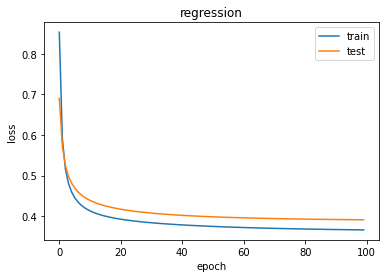

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('regression')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## Plot distribution of output probabilities  for signal and backround

The output of the classification is for each event a number between 0 and 1 representing the probability that that event is a signal event. Since for each event we know whether it was a signal (SIG=1) or a background (SIG=0), we can plot the output probability of the network for each of the two classes.


nsig  2523
nbkg  2477


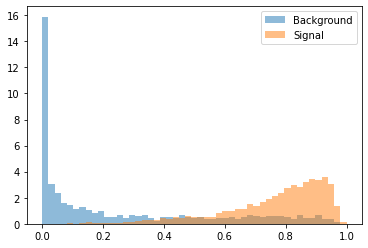

In [26]:
# split according to the label
df_test_acc_r_bkg = df_test_acc_r.query('SIG==0')
df_test_acc_r_sig = df_test_acc_r.query('SIG==1')
print('nsig ',df_test_acc_r_sig.shape[0])
print('nbkg ',df_test_acc_r_bkg.shape[0])
bins = np.linspace(0, 1,50)
plt.hist(df_test_acc_r_bkg.PROB, bins, alpha=0.5, density=True, label='Background')
plt.hist(df_test_acc_r_sig.PROB, bins, alpha=0.5, density=True, label='Signal')
plt.legend(loc='best')
plt.show()

## Plot ROC curve and calculate AUC
In order to perform our the final selection we put a lower limit on the value of the probability and we count the fraction of events above this limit for both signal and backround, i.e for each value of PROB we have two values: The 'true positive rate (TPR)' (efficiency of signal selection in HEP language), and 'false positive rate (FPR)' (efficency for selecting background). If we TPR versus FPR the other as a function of PROB we obtain a curve called the Receive Operating Characteristic (ROC) curve https://en.wikipedia.org/wiki/Receiver_operating_characteristic. Methods for building the ROC curve are availabel in sklearn.metrics. An ideal ROC curve would be along upper x and left y axes of the plot, corresponding to the case where all of the signal events have PROB=1 and all background events have PROB=0. The worst case is a curve where TPR=FPR, i.e. the discrimination power is the same as extracting a random number for PROB.

Regression auc  0.8988352774178806


<function matplotlib.pyplot.show(close=None, block=None)>

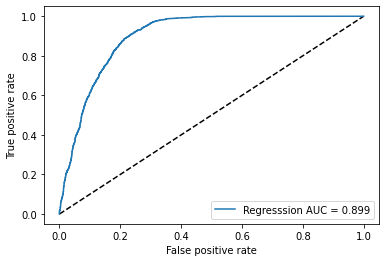

In [27]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

plt.plot([0.001, 1], [0, 1], 'k--')
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, Ypredr)
auc_keras = auc(fpr_keras, tpr_keras)
print("Regression auc ",auc_keras)
plt.plot(fpr_keras, tpr_keras, label='Regresssion AUC = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='best')
plt.show    


## Compare label and prediction in 1-d projections

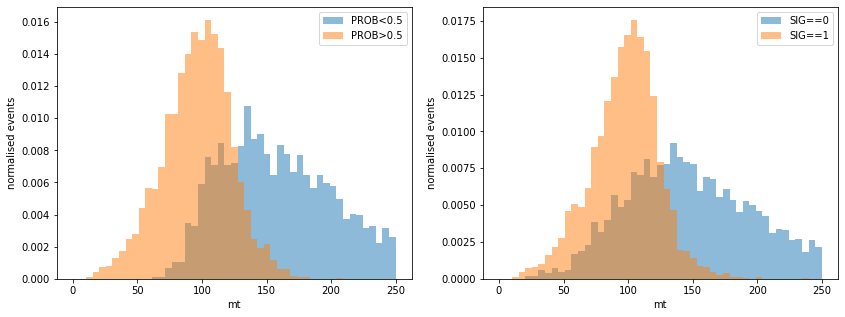

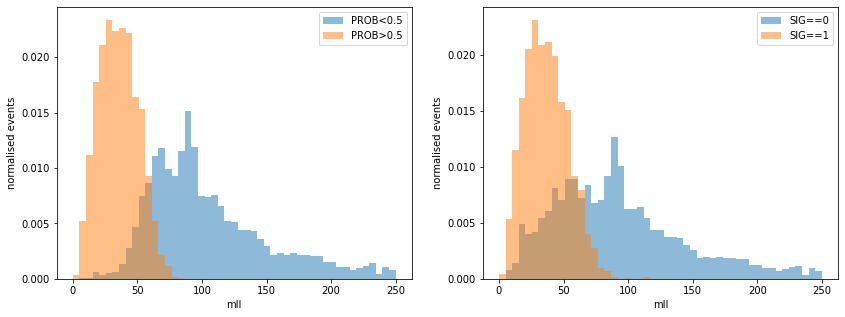

In [38]:
pred_false='PROB<0.5'
pred_true='PROB>0.5'
lab_false='SIG==0'
lab_true='SIG==1'
nbin=50
blow=0.
fig1= plt.figure(figsize=(14,5))
plt.subplot(1, 2,1)
var="mt"
varmin=0.
varmax=250.
scale=MeV
bins = np.linspace(varmin , varmax, nbin)
plt.hist(df_test_acc_r.query(pred_false)[var]*scale, bins, alpha=0.5, density=True, label=pred_false)
plt.hist(df_test_acc_r.query(pred_true)[var]*scale, bins, alpha=0.5, density=True, label=pred_true)
plt.legend(loc='best')
plt.xlabel(var)
plt.ylabel('normalised events')
plt.subplot(1, 2,2)
plt.hist(df_test_acc_r.query(lab_false)[var]*MeV, bins, alpha=0.5, density=True, label=lab_false)
plt.hist(df_test_acc_r.query(lab_true)[var]*MeV, bins, alpha=0.5, density=True, label=lab_true)
plt.legend(loc='best')
plt.xlabel(var)
plt.ylabel('normalised events')
plt.show()
var="mll"
varmin=0.
varmax=250
scale=MeV
bins = np.linspace(varmin , varmax, nbin)
fig2= plt.figure(figsize=(14,5))
plt.subplot(1, 2,1)
plt.hist(df_test_acc_r.query(pred_false)[var]*MeV, bins, alpha=0.5, density=True, label=pred_false)
plt.hist(df_test_acc_r.query(pred_true)[var]*MeV, bins, alpha=0.5, density=True, label=pred_true)
plt.legend(loc='best')
plt.xlabel(var)
plt.ylabel('normalised events')
plt.subplot(1, 2,2)
plt.hist(df_test_acc_r.query(lab_false)[var]*MeV, bins, alpha=0.5, density=True, label=lab_false)
plt.hist(df_test_acc_r.query(lab_true)[var]*MeV, bins, alpha=0.5, density=True, label=lab_true)
plt.legend(loc='best')
plt.xlabel(var)
plt.ylabel('normalised events')
plt.show()

## Visualise weights

In [29]:
layer_weights = model.layers[0].get_weights()[0]
layer_biases  = model.layers[0].get_weights()[1]
print('variable names',col_fin)
print('layer weights',layer_weights)
print('layer biases',layer_biases)

variable names Index(['ptl1', 'ptl2', 'dphil1m', 'dphil2m', 'etal1', 'etal2', 'met_et', 'mll',
       'mt', 'ptll', 'dphill', 'dphillm'],
      dtype='object')
layer weights [[-0.31884354]
 [-0.35237622]
 [-0.02594792]
 [-0.01634728]
 [ 0.0541401 ]
 [-0.05537266]
 [-0.17010815]
 [-2.2411165 ]
 [-2.0206728 ]
 [ 0.32245827]
 [-0.21945861]
 [ 0.41100436]]
layer biases [-1.0882626]


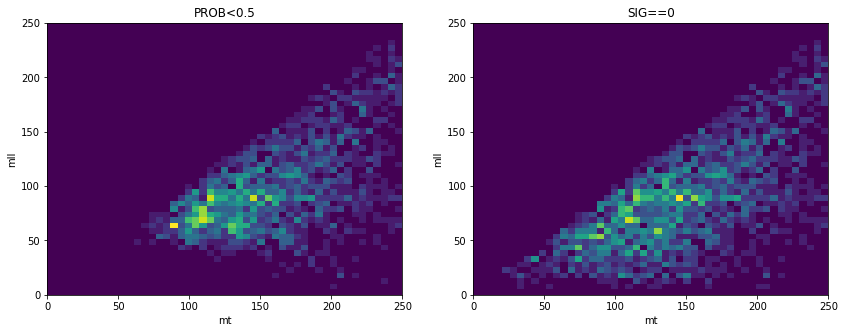

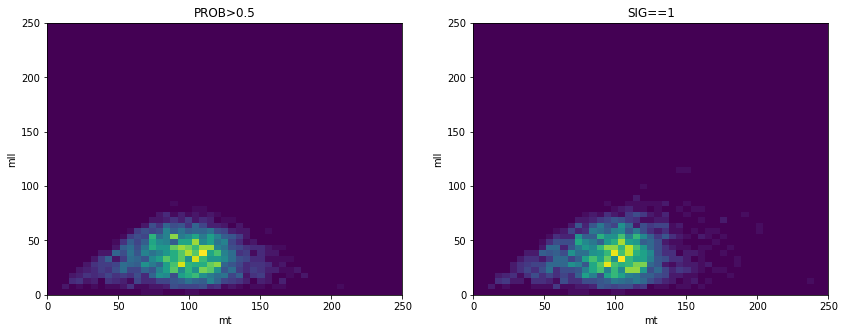

In [30]:
pred_false='PROB<0.5'
pred_true='PROB>0.5'
lab_false='SIG==0'
lab_true='SIG==1'
varx="mt"
varminx=0.
varmaxx=250.
nbinx=50
scalex=MeV
vary="mll"
nbiny=50
varminy=0.
varmaxy=250
scaley=MeV
binx = np.linspace(varminx,varmaxx,nbinx)
biny = np.linspace(varminy,varmaxy,nbiny)
fig1= plt.figure(figsize=(14,5))
plt.subplot(1, 2,1)
plt.hist2d(df_test_acc_r.query(pred_false)[varx]*scalex, df_test_acc_r.query(pred_false)[vary]*scaley, 
           bins=[binx, biny], density=False)
plt.xlabel(varx)
plt.ylabel(vary)
plt.title(pred_false)
plt.subplot(1, 2,2)
plt.hist2d(df_test_acc_r.query(lab_false)[varx]*scalex, df_test_acc_r.query(lab_false)[vary]*scaley, 
           bins=[binx, biny], density=False)
plt.xlabel(varx)
plt.ylabel(vary)
plt.title(lab_false)
plt.show()
fig2= plt.figure(figsize=(14,5))
plt.subplot(1, 2,1)
plt.hist2d(df_test_acc_r.query(pred_true)[varx]*scalex, df_test_acc_r.query(pred_true)[vary]*scaley, 
           bins=[binx, biny], density=False)
plt.xlabel(varx)
plt.ylabel(vary)
plt.title(pred_true)
plt.subplot(1, 2,2)
plt.hist2d(df_test_acc_r.query(lab_true)[varx]*scalex, df_test_acc_r.query(lab_true)[vary]*scaley, 
           bins=[binx, biny], density=False)
plt.xlabel(varx)
plt.ylabel(vary)
plt.title(lab_true)
plt.show()

# Decision tree classifier

Documentation for the possible options is in <br />

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
    

In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

test_tree = pd.DataFrame(X_testu)
test_tree.columns=col_fin

clf = DecisionTreeClassifier(max_leaf_nodes=6, criterion='gini', splitter='best', random_state=0)
clf.fit(X_trainu, y_train)


Ypredt=clf.predict_proba(test_tree)

print('Training finished')

Training finished


In [32]:
print(Ypredt.shape)
df_test_acc_t=X_testu.copy()
df_test_acc_t['SIG']=y_test
df_test_acc_t['PROB']=Ypredt[:,1]

(5000, 2)


## Plot distribution of output probabilities  for signal and backround

nsig  2523
nbkg  2477


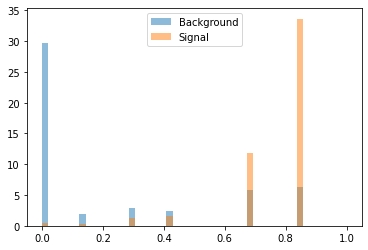

In [33]:
# split according to the label
df_test_acc_t_bkg = df_test_acc_t.query('SIG==0')
df_test_acc_t_sig = df_test_acc_t.query('SIG==1')
print('nsig ',df_test_acc_t_sig.shape[0])
print('nbkg ',df_test_acc_t_bkg.shape[0])
bins = np.linspace(0, 1,50)
plt.hist(df_test_acc_t_bkg.PROB, bins, alpha=0.5, density=True, label='Background')
plt.hist(df_test_acc_t_sig.PROB, bins, alpha=0.5, density=True, label='Signal')
plt.legend(loc='best')
plt.show()

## Plot ROC curve and calculate AUC

Regression auc  0.8846936804731151


<function matplotlib.pyplot.show(close=None, block=None)>

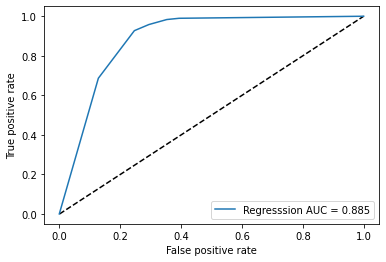

In [34]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

plt.plot([0.001, 1], [0, 1], 'k--')
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, Ypredt[:,1])
auc_keras = auc(fpr_keras, tpr_keras)
print("Regression auc ",auc_keras)
plt.plot(fpr_keras, tpr_keras, label='Regresssion AUC = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='best')
plt.show    


## Compare label and prediction in 1-d projections

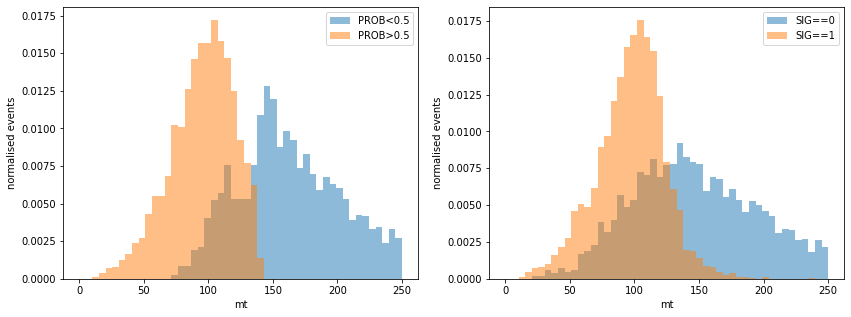

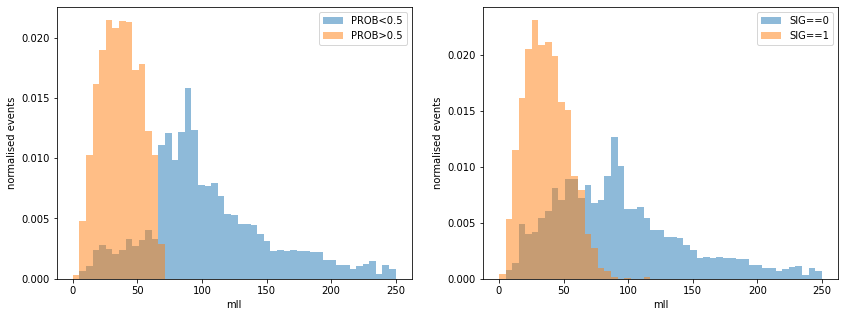

In [35]:
pred_false='PROB<0.5'
pred_true='PROB>0.5'
lab_false='SIG==0'
lab_true='SIG==1'
nbin=50
fig3= plt.figure(figsize=(14,5))
plt.subplot(1, 2,1)
var="mt"
varmin=0.
varmax=250.
scale=MeV
bins = np.linspace(varmin , varmax, nbin)
plt.hist(df_test_acc_t.query(pred_false)[var]*scale, bins, alpha=0.5, density=True, label=pred_false)
plt.hist(df_test_acc_t.query(pred_true)[var]*scale, bins, alpha=0.5, density=True, label=pred_true)
plt.legend(loc='best')
plt.xlabel(var)
plt.ylabel('normalised events')
plt.subplot(1, 2,2)
plt.hist(df_test_acc_t.query(lab_false)[var]*MeV, bins, alpha=0.5, density=True, label=lab_false)
plt.hist(df_test_acc_t.query(lab_true)[var]*MeV, bins, alpha=0.5, density=True, label=lab_true)
plt.legend(loc='best')
plt.xlabel(var)
plt.ylabel('normalised events')
plt.show()
var="mll"
varmin=0.
varmax=250
scale=MeV
bins = np.linspace(varmin , varmax, nbin)
fig4= plt.figure(figsize=(14,5))
plt.subplot(1, 2,1)
plt.hist(df_test_acc_t.query(pred_false)[var]*scale, bins, alpha=0.5, density=True, label=pred_false)
plt.hist(df_test_acc_t.query(pred_true)[var]*scale, bins, alpha=0.5, density=True, label=pred_true)
plt.legend(loc='best')
plt.xlabel(var)
plt.ylabel('normalised events')
plt.subplot(1, 2,2)
plt.hist(df_test_acc_t.query(lab_false)[var]*scale, bins, alpha=0.5, density=True, label=lab_false)
plt.hist(df_test_acc_t.query(lab_true)[var]*scale, bins, alpha=0.5, density=True, label=lab_true)
plt.legend(loc='best')
plt.xlabel(var)
plt.ylabel('normalised events')
plt.show()

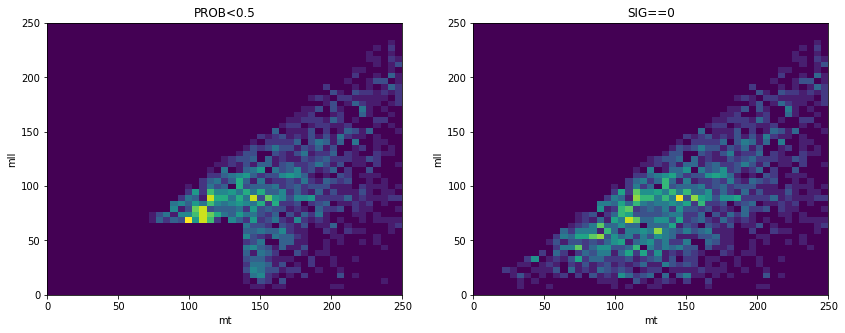

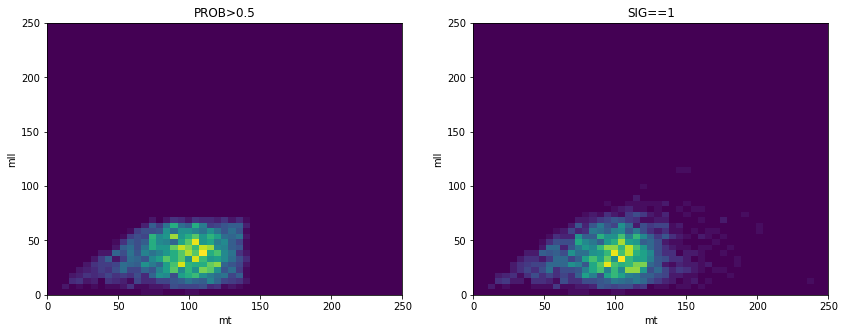

In [36]:
pred_false='PROB<0.5'
pred_true='PROB>0.5'
lab_false='SIG==0'
lab_true='SIG==1'
varx="mt"
varminx=0.
varmaxx=250.
nbinx=50
scalex=MeV
vary="mll"
nbiny=50
varminy=0.
varmaxy=250.
scaley=MeV
binx = np.linspace(varminx,varmaxx,nbinx)
biny = np.linspace(varminy,varmaxy,nbiny)
fig1= plt.figure(figsize=(14,5))
plt.subplot(1, 2,1)
plt.hist2d(df_test_acc_t.query(pred_false)[varx]*scalex, df_test_acc_t.query(pred_false)[vary]*scaley, 
           bins=[binx, biny], density=False)
plt.xlabel(varx)
plt.ylabel(vary)
plt.title(pred_false)
plt.subplot(1, 2,2)
plt.hist2d(df_test_acc_t.query(lab_false)[varx]*scalex, df_test_acc_t.query(lab_false)[vary]*scaley, 
           bins=[binx, biny], density=False)
plt.xlabel(varx)
plt.ylabel(vary)
plt.title(lab_false)
plt.show()
fig2= plt.figure(figsize=(14,5))
plt.subplot(1, 2,1)
plt.hist2d(df_test_acc_t.query(pred_true)[varx]*scalex, df_test_acc_t.query(pred_true)[vary]*scaley, 
           bins=[binx, biny], density=False)
plt.xlabel(varx)
plt.ylabel(vary)
plt.title(pred_true)
plt.subplot(1, 2,2)
plt.hist2d(df_test_acc_t.query(lab_true)[varx]*scalex, df_test_acc_t.query(lab_true)[vary]*scaley, 
           bins=[binx, biny], density=False)
plt.xlabel(varx)
plt.ylabel(vary)
plt.title(lab_true)
plt.show()

## Visualize tree

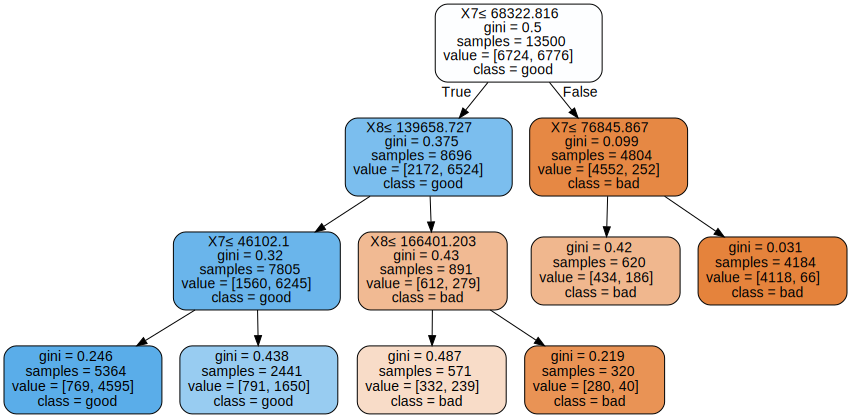

In [37]:
import graphviz
dot_data = tree.export_graphviz(clf, out_file=None)
dot_data = tree.export_graphviz(clf, out_file=None,
                     class_names=["bad","good"],
                     filled=True, rounded=True,
                     special_characters=True)
graph = graphviz.Source(dot_data)
graph

# Exercises

* Try to run Logistic Regression with non-renormalised variables and extract best significance
* Try to change optimiser for logistic regression 
* Try to remove the variables with lowest weights, and compare performance

* Add one layer to the LR model and compare performance -> this is the shallow learning
  * Vary parameters of added layer

* Modify parameteres in decision tree
  * In particular, increase number of leaves, and verify on graphical representation of the tree what id did 
* Rerun decision tree only with variables actually used by tree
